# Comparative Numerical Exp of SGD v.s. Direct Convex Optimization

## Conic Optimization

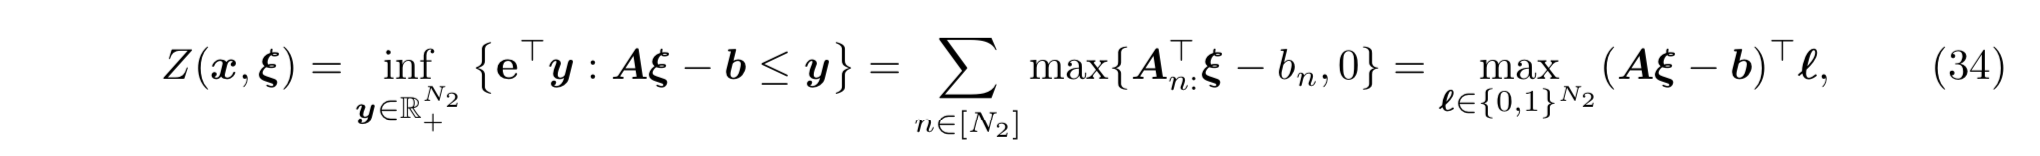

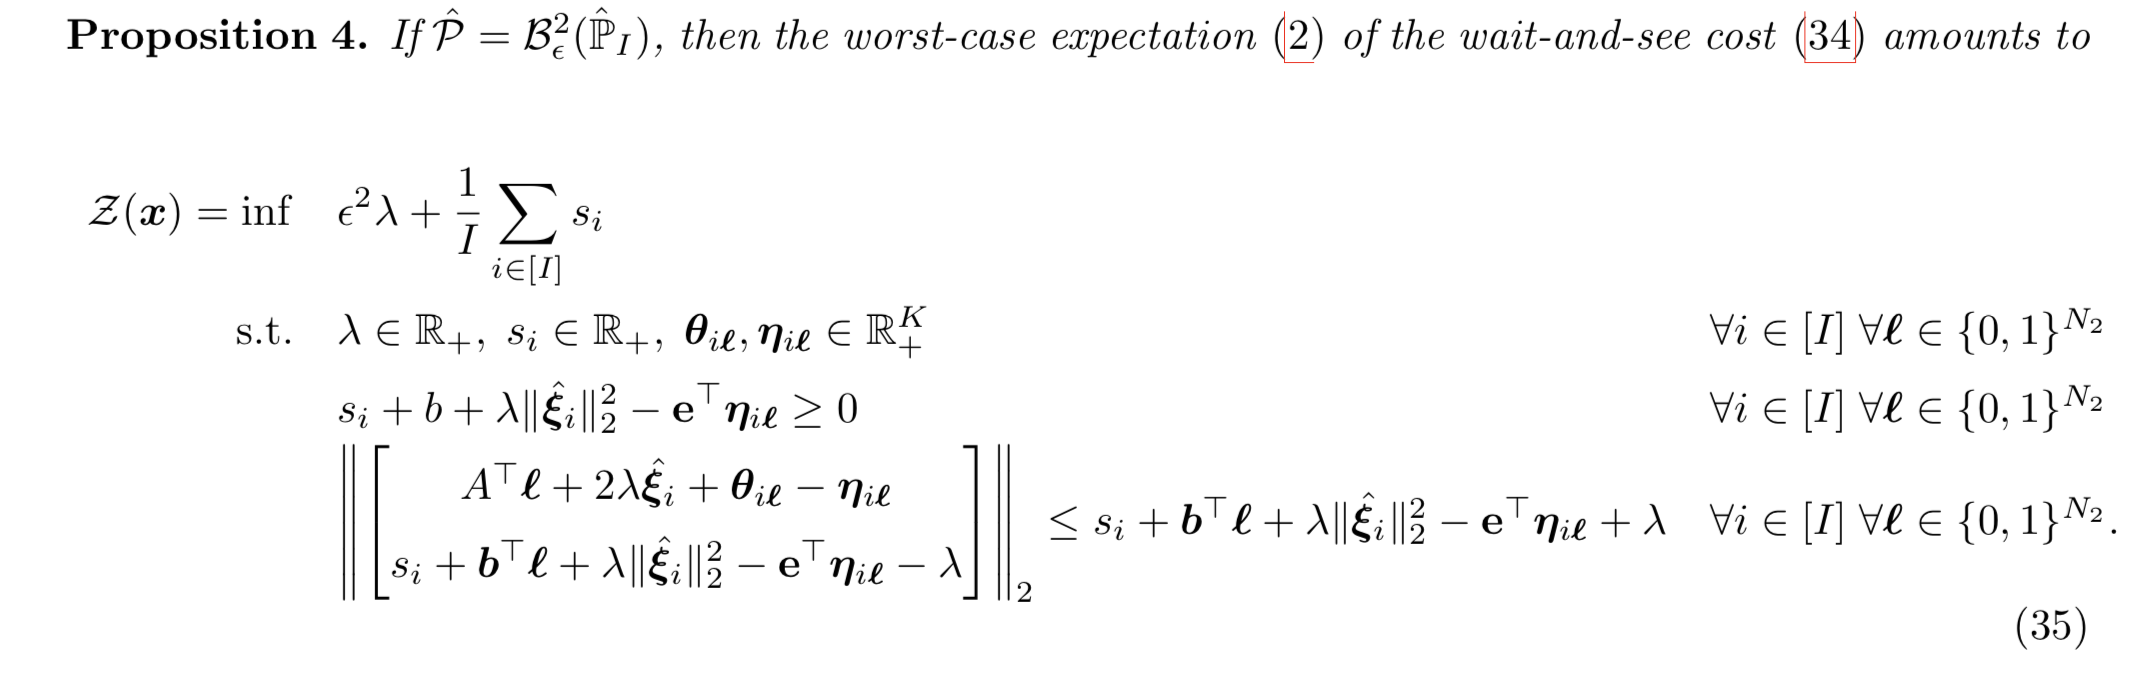

Suppose that the loss function is 
$$
\ell(x,\beta; y) = \|y-\beta^{\top} x\|^2
$$
Let $A(X_i) = I$, the problem is SQRT LASSO:
$$
\inf_{\beta\in B}\inf_{\lambda\geq0} \left\{
\lambda\sqrt{\delta}+
\frac{1}{n} \sum_{i=1}^{n}%
\frac{\lambda(\beta^{T}X_{i}-Y_{i})^{2}}{\lambda-\sqrt{\delta}\|\beta\|^2} \right\}
= \inf_{\beta\in B}
\left\{
\left(\sqrt{E[\|Y-\beta^{\top} X\|^2]}+\sqrt{\delta}\|\beta\|\right)^2
\right\}
$$

In [1]:
import cvxpy as cvx
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import numba
import matplotlib.pyplot as plt

In [2]:
from functools import wraps
from time import time

def timing(f):
    @wraps(f)
    def wrap(*args, **kw):
        ts = time()
        result = f(*args, **kw)
        te = time()
        #print('func:%r took: %2.4f sec' % (f.__name__, te-ts))
        return result, te-ts
    return wrap

In [3]:
class LinearRegressionDataGenerator(object):
    """
    Data Generator for Linear Regression Model
    y = X * var + epsilon
    ================
    Member Variables
    ================
    var            : ground true parameter for linear regression model
    dim            : the dimension for the linear regression model
    std            : standard deviation for the noise
    """

    def __init__(self, var, std = 0.1):
        var = np.array(var)
        assert(var.ndim is 1)

        self.var = var
        self.dim = var.size
        self.std = std

    def generate(self, data_num):
        X = np.random.rand(data_num, self.dim)
        y = X.dot(self.var) + self.std * np.random.randn(data_num)
        return X, y

In [4]:
d = 16; n = 256; delta = 0.1; sqrt_delta = np.sqrt(delta)
np.random.seed(42)
true_beta = np.random.randn(d)
X, y = LinearRegressionDataGenerator(true_beta).generate(n)
X = np.hstack([np.ones((n,1)), X])

In [5]:
def sqrt_LASSO(X, y, delta):
    n, d = X.shape
    sqrt_delta = np.sqrt(delta)
    s = cvx.Variable(1, nonneg = True)
    lambda_ = cvx.Variable(1, nonneg = True)
    beta = cvx.Variable(d)
    diff = cvx.matmul(X,beta) - y
    obj = cvx.Minimize(lambda_*sqrt_delta + cvx.quad_over_lin(diff,1-s) / n)
    constraints = [s >= sqrt_delta*cvx.quad_over_lin(beta,lambda_)]
    prob = cvx.Problem(obj, constraints)
    prob.solve(verbose = False)
    return beta.value, prob.value
opt_beta, opt_val = sqrt_LASSO(X, y, delta)
opt_beta, opt_val

(array([-0.00357094,  0.000307  , -0.00362255,  0.00103654,  0.00326272,
        -0.00258505, -0.00328857,  0.0038676 ,  0.00169634, -0.00161507,
        -0.00010555, -0.00269976, -0.00203343, -0.00148676, -0.00734881,
        -0.00788012, -0.00299203]), 1.0450461869988859)

In [6]:
@numba.njit(fastmath = False)
def SGD_DR_Linear_Regression(X, y, beta_init, lambda_init, max_iter = 100000):
    lambda_path, beta_path, loss_path = [], [], []
    lambda_, beta = lambda_init, beta_init
    for i in range(max_iter):
        idx = np.random.choice(X.shape[0])
        X_sample, y_sample = X[idx], y[idx]
        anc1 = sqrt_delta * np.sum(beta**2)
        gamma_sample = (X_sample.dot(beta) - y_sample) / (lambda_ - anc1)
        transport_X_sample = X_sample + sqrt_delta * gamma_sample * beta

        grad_beta = 2 * (transport_X_sample.dot(beta) - y_sample) * transport_X_sample
        grad_lambda = -sqrt_delta * (np.square(gamma_sample)*beta.dot(beta) - 1)
        loss = (np.sqrt(np.sum((y - X @ beta)**2)/X.shape[0])+sqrt_delta*np.linalg.norm(beta))**2
        step = min(0.05, 0.1/(i+1) ** 0.55)
        lambda_path.append(lambda_), beta_path.append(beta), loss_path.append(loss)
        beta = beta - step*grad_beta
        lambda_ = max(lambda_ - step*grad_lambda, sqrt_delta * np.sum(beta**2)+1e-3) 
    return lambda_path, beta_path, loss_path

@numba.njit(fastmath = False)
def SGD_DR_Linear_Regression_simple(X, y, beta_init, lambda_init, max_iter = 100000):
    lambda_, beta = lambda_init, beta_init
    for i in range(max_iter):
        idx = np.random.choice(X.shape[0])
        X_sample, y_sample = X[idx], y[idx]
        anc1 = sqrt_delta * np.sum(beta**2)
        gamma_sample = (X_sample.dot(beta) - y_sample) / (lambda_ - anc1)
        transport_X_sample = X_sample + sqrt_delta * gamma_sample * beta

        grad_beta = 2 * (transport_X_sample.dot(beta) - y_sample) * transport_X_sample
        grad_lambda = -sqrt_delta * (np.square(gamma_sample)*beta.dot(beta) - 1)
        step = min(0.05, 0.1/(i+1) ** 0.55)
        beta = beta - step*grad_beta
        lambda_ = max(lambda_ - step*grad_lambda, sqrt_delta * np.sum(beta**2)+1e-3) 
    return lambda_, beta

@timing
@numba.njit(fastmath = False)
def SGD_DR_Linear_Regression_timing(X, y, beta_init, lambda_init, max_iter = 100000):
    lambda_, beta = lambda_init, beta_init
    for i in range(max_iter):
        idx = np.random.choice(X.shape[0])
        X_sample, y_sample = X[idx], y[idx]
        anc1 = sqrt_delta * np.sum(beta**2)
        gamma_sample = (X_sample.dot(beta) - y_sample) / (lambda_ - anc1)
        transport_X_sample = X_sample + sqrt_delta * gamma_sample * beta

        grad_beta = 2 * (transport_X_sample.dot(beta) - y_sample) * transport_X_sample
        grad_lambda = -sqrt_delta * (np.square(gamma_sample)*beta.dot(beta) - 1)
        step = min(0.05, 0.1/(i+1) ** 0.55)
        beta = beta - step*grad_beta
        lambda_ = max(lambda_ - step*grad_lambda, sqrt_delta * np.sum(beta**2)+1e-3) 
    return lambda_, beta

In [7]:
beta_init, lambda_init = 0.1*np.random.randn(X.shape[1]), 0.8
lambda_path, beta_path, loss_path = SGD_DR_Linear_Regression(X, y, beta_init, lambda_init)
(_, _), SGD_time = SGD_DR_Linear_Regression_timing(X, y, beta_init, lambda_init)

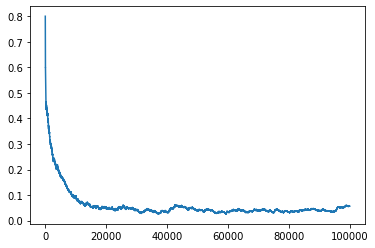

In [8]:
plt.plot(lambda_path)

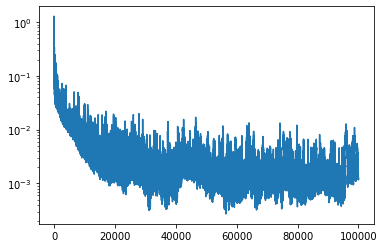

In [9]:
plt.semilogy(loss_path - opt_val)
plt.show()

The loss function is $\ell(x;\beta) = (y-\beta^{\top}x)^2$. Suppose that we approximate the $x^2$ function at points $[c_1, \ldots, c_k]$. Then 
$$
x^2 \geq \max_k 2c_k x - c_k^2
$$
Then it follows that 
$$\ell(x;\beta) = (y-\beta^{\top}x)^2
\geq max_k\left\{
2c_k \beta^{\top}x
-2c_k y - c^2_k
\right\} 
$$ 

\begin{align*}
\begin{array}{ll}
\inf & \lambda\delta + \frac{1}{N} \sum_{i = 1}^N s_i\\
\mathrm{s.t.} &  \lambda\in\mathbb{R}_{+}, s_i \in \mathbb{R}_+, \\
&\max_{x} 2c_k \beta^{\top}x -2c_k \hat{y}_i - c^2_k - \lambda\|x-\hat{x}_i\|^2 \leq s_i
\end{array}
\end{align*}
Notice that 
$$
\max_{x} 2c_k \beta^{\top}x -2c_k \hat{y}_i - c^2_k - \lambda\|x-\hat{x}_i\|^2 
= 2c_k \beta^{\top}\hat{x}_i -2c_k \hat{y}_i - c^2_k + c_k^2\|\beta\|^2/\lambda
$$
so the problem can be reformulated as 
\begin{align*}
\begin{array}{ll}
\inf & \lambda\delta + \frac{1}{N} \sum_{i = 1}^N s_i\\
\mathrm{s.t.} &  \lambda\in\mathbb{R}_{+}, s_i \in \mathbb{R}_+, \\
& c_k^2\|\beta\|^2/\lambda \leq s_i+2c_k \hat{y}_i + c^2_k - 2c_k \beta^{\top}\hat{x}_i, \qquad\forall k, i
\end{array}
\end{align*}
which is a SOCP problem
\begin{align*}
\begin{array}{ll}
\inf & \lambda\delta + \frac{1}{N} \sum_{i = 1}^N s_i\\
\mathrm{s.t.} &  \lambda\in\mathbb{R}_{+}, s_i \in \mathbb{R}_+, \\
& A_{ik} = s_i+2c_k \hat{y}_i + c^2_k - 2c_k \beta^{\top}\hat{x}_i \geq 0,\\
& \left\Vert
  \begin{array}{c}
  2c_k\beta\\
  s_i+2c_k \hat{y}_i + c^2_k - 2c_k \beta^{\top}\hat{x}_i - \lambda
  \end{array}
  \right\Vert_2
  \leq s_i+2c_k \hat{y}_i + c^2_k - 2c_k \beta^{\top}\hat{x}_i + \lambda\qquad \forall k, i
\end{array}
\end{align*}

In [10]:
def SOCP_approx_Linear_Regression(X, y, c_k, delta):
    n, d = X.shape
    sqrt_delta = np.sqrt(delta)
    beta = cvx.Variable(d)
    K = c_k.shape[0]
    lambda_ = cvx.Variable(1, nonneg = True)
    s = cvx.Variable(n, nonneg = True)
    A = cvx.vstack([s]*K).T + 2*(y.reshape((-1,1)) * c_k) + (c_k ** 2).reshape((1,-1))\
        -2 * cvx.multiply(c_k.reshape((1,-1)), cvx.matmul(X, cvx.vstack([beta]*K).T))
    constraints = [
        (cvx.norm2(cvx.hstack([cvx.vstack([2*c_k[k]*beta]*n), 
                              cvx.reshape(A[:,k] - lambda_, (n,1))]), axis = 1) 
         <= A[:,k] + lambda_) for k in range(K)
    ]
    constraints.append(A>=0)
    obj = cvx.Minimize(lambda_ + cvx.sum(s)/n)
    prob = cvx.Problem(obj, constraints)
    prob.solve()
    return (beta.value, prob.value), prob.solver_stats.solve_time

In [11]:
def robust_loss(X, y, beta, delta):
    return (np.sqrt(np.sum((y - X @ beta)**2)/X.shape[0])+np.sqrt(delta)*np.linalg.norm(beta))**2

In [12]:
c_k = np.array([-1, -0.5, -0.2, -0.1, -0.05, 0, 0.05, 0.1, 0.2, 0.5, 1], dtype = float)
(socp_beta, socp_val), socp_time = SOCP_approx_Linear_Regression(X, y, c_k, delta)
socp_beta, socp_val

(array([-3.88313248e-13,  8.20698858e-14, -4.77870534e-13,  5.05133156e-14,
         3.01017896e-13, -2.18082072e-13, -3.03908016e-13,  2.57413824e-13,
         1.61375688e-13, -7.69442402e-14, -1.50595211e-13, -3.16519608e-13,
        -2.96229898e-13, -1.63874383e-13, -7.13603332e-13, -7.81162565e-13,
        -2.20201085e-13]), 0.8782641030640015)

In [13]:
robust_loss(X, y, socp_beta, delta)

1.04529305267822

# Test of algorithm efficiency

In [14]:
d = 16; np.random.seed(42); true_beta = np.random.randn(d)
delta = 0.1; window = 1000
n = 256; 
c_k = np.linspace(-1, 1, 9)

In [15]:
sqrt_delta = np.sqrt(delta)
X, y = LinearRegressionDataGenerator(true_beta).generate(n)
X = np.hstack([np.ones((n,1)), X])
opt_beta, opt_val = sqrt_LASSO(X, y, delta)
(socp_beta, socp_val), socp_time = SOCP_approx_Linear_Regression(X, y, c_k, delta)
beta_init, lambda_init = 0.1*np.random.randn(X.shape[1]), 0.8
lambda_path, beta_path, loss_path = SGD_DR_Linear_Regression(X, y, beta_init, lambda_init, max_iter = int(1e6))
socp_opt_gap = robust_loss(X, y, socp_beta, delta) - opt_val
stop_iter = np.where(np.convolve(np.array(loss_path) - opt_val, 
                     np.ones(window)/window, mode='valid') < socp_opt_gap)[0][0] + window - 1
print('socp_opt_gap = {}, \tstop iterate when i = {}'.format(socp_opt_gap,stop_iter))
(_, _), SGD_time = SGD_DR_Linear_Regression_timing(X, y, beta_init, lambda_init, max_iter=stop_iter)

socp_opt_gap = 0.00024686567925957803, 	stop iterate when i = 322820


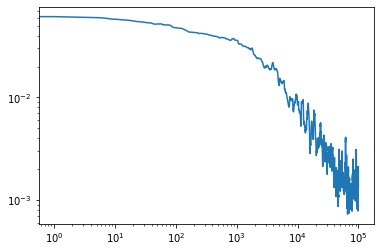

In [16]:
plt.loglog(np.convolve(np.array(loss_path) - opt_val, np.ones(window)/window, mode='valid')[:100000])

In [17]:
def single_n_exp(true_beta, delta, n, c_k):
    res_table = pd.DataFrame(columns = ['sample_num', 'socp_opt_gap', 'stop_iter', 'socp_time', 'SGD_time'])
    for exp in tqdm(range(50)):
        sqrt_delta = np.sqrt(delta)
        X, y = LinearRegressionDataGenerator(true_beta).generate(n)
        X = np.hstack([np.ones((n,1)), X])
        opt_beta, opt_val = sqrt_LASSO(X, y, delta)
        (socp_beta, socp_val), socp_time = SOCP_approx_Linear_Regression(X, y, c_k, delta)
        beta_init, lambda_init = 0.1*np.random.randn(X.shape[1]), 5
        lambda_path, beta_path, loss_path = SGD_DR_Linear_Regression(X, y, beta_init, lambda_init, max_iter = int(1e6))
        socp_opt_gap = robust_loss(X, y, socp_beta, delta) - opt_val
        stop_iter = np.where(np.convolve(np.array(loss_path) - opt_val, 
                             np.ones(window)/window, mode='valid') < min(0.005, socp_opt_gap))[0][0] + window - 1
        ts = time()
        SGD_DR_Linear_Regression_simple(X, y, beta_init, lambda_init, max_iter=stop_iter)
        te = time()
        SGD_time = te - ts
        res_table = res_table.append({'sample_num':n, 
                                      'socp_opt_gap':socp_opt_gap, 
                                      'stop_iter':stop_iter,
                                      'socp_time':socp_time, 
                                      'SGD_time':SGD_time}, ignore_index = True)
    return res_table

In [18]:
#res_table = single_n_exp(true_beta, delta, n, c_k)

In [19]:
def experiment():
    n_list = [16, 32, 64, 128, 256, 512, 1024]
    res_list = []
    np.random.seed(2)
    true_beta = np.random.randn(d)
    delta = 0.1; window = 1000
    c_k = np.linspace(-5, 5, 19)
    for n in tqdm(n_list, desc = 'nlist', leave = False):
        res_list.append(single_n_exp(true_beta, delta, n, c_k))
    res = pd.concat(res_list).reset_index(drop = True)
    res.to_pickle('comparative_efficiency_exp_K_19.pkl')

In [20]:
experiment()

In [21]:
temp_table = pd.read_pickle('comparative_efficiency_exp_K_19.pkl').groupby('sample_num').mean()

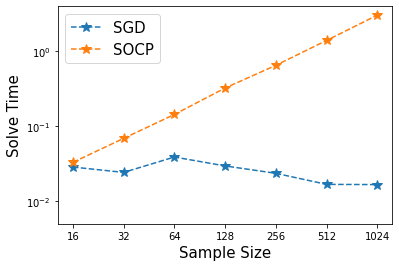

In [22]:
plt.loglog(temp_table.index, temp_table.SGD_time, '--*', markersize = 10)
plt.loglog(temp_table.index, temp_table.socp_time, '--*', markersize = 10)
plt.xlabel("Sample Size", fontsize = 15)
plt.ylabel("Solve Time", fontsize = 15)
plt.legend(["SGD", "SOCP"],fontsize = 15)
plt.ylim([0.005,4])
plt.xticks(temp_table.index,temp_table.index.astype(int))
plt.minorticks_off()
#plt.show()
plt.savefig("convergence_rate_fig/sgd_socp_K_19.pdf")